
Load Necessary Libraries

In [1]:
import os
import glob
from skimage import io, feature, exposure
from scipy.fft import fft2, fftshift
import numpy as np
import matplotlib.pyplot as plt
import cv2

Godd vs Anolomous Images

No. of Good Images 23
No. of Anolomous Images 109


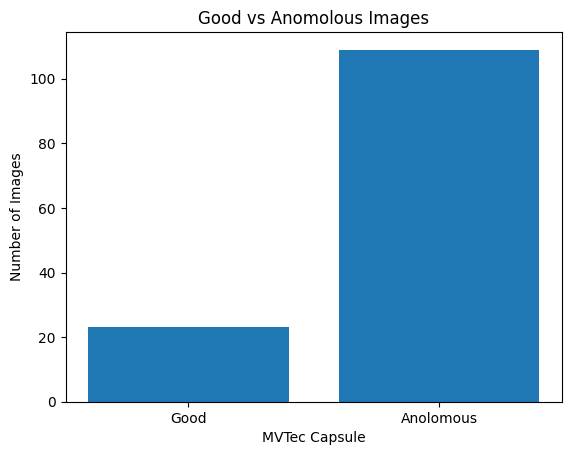

Total number of images: 132
Sample labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [4]:
import os
import glob
from skimage import io, feature, exposure
from scipy.fft import fft2, fftshift
import numpy as np
import matplotlib.pyplot as plt
import cv2


def binary_label_images(train_data, test_data):
    labels = {}

    #  label 0 for good images
    train_images = glob.glob(os.path.join(train_data, '*.png'))
    for img_path in train_images:
        labels[img_path] = 0

    #  label 1 for bad images
    if isinstance(test_data, str):
        test_data = [test_data]  # Convert single folder path to a list

    for folder in test_data:
        test_images = glob.glob(os.path.join(folder, '*.png'))
        for img_path in test_images:
            labels[img_path] = 1

    # Count the number of good and bad images
    train_good_images = sum(label == 0 for label in labels.values())
    print("No. of Good Images", train_good_images)
    test_images = sum(label == 1 for label in labels.values())
    print("No. of Anolomous Images", test_images)

    # Create a bar chart
    categories = ['Good', 'Anolomous']
    counts = [train_good_images, test_images]

    plt.bar(categories, counts)
    plt.xlabel('MVTec Capsule')
    plt.ylabel('Number of Images')
    plt.title('Good vs Anomolous Images')
    plt.show()

#     print("Number of  good images:", train_good_images)
#     print("Number of bad images:", test_images)
    print("Total number of images:", len(labels))
    print("Sample labels:", list(labels.values())[:329])

    return labels

train_folder = '/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/good'
test_folders = ['/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/crack', '/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/poke','/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/squeeze','/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/scratch', '/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/faulty_imprint']

truth_labels = binary_label_images(train_folder, test_folders)

전처리 및 이미지 확대 적용
COLOR_RGB2GRAY를 사용하여 이미지를 그레이스케일링: 2D FFT를 적용할 예정이므로 이 작업을 수행합니다

이미지를 정규화: 정규화에는 일반적으로 이미지의 픽셀 값을 0과 1 사이의 특정 범위로 스케일링하는 작업이 포함됩니다. FFT를 적용하기 전에 영상을 정규화함으로써 주파수 분석이 일관되고 표준화된 입력 데이터를 기반으로 합니다

 Canny Edge 적용: 우리는 가장자리를 찾기 위해  Canny Edge 알고리즘을 적용합니다. 이를 나중에 함수에서 사용하여 anomaly_mask를 계산합니다

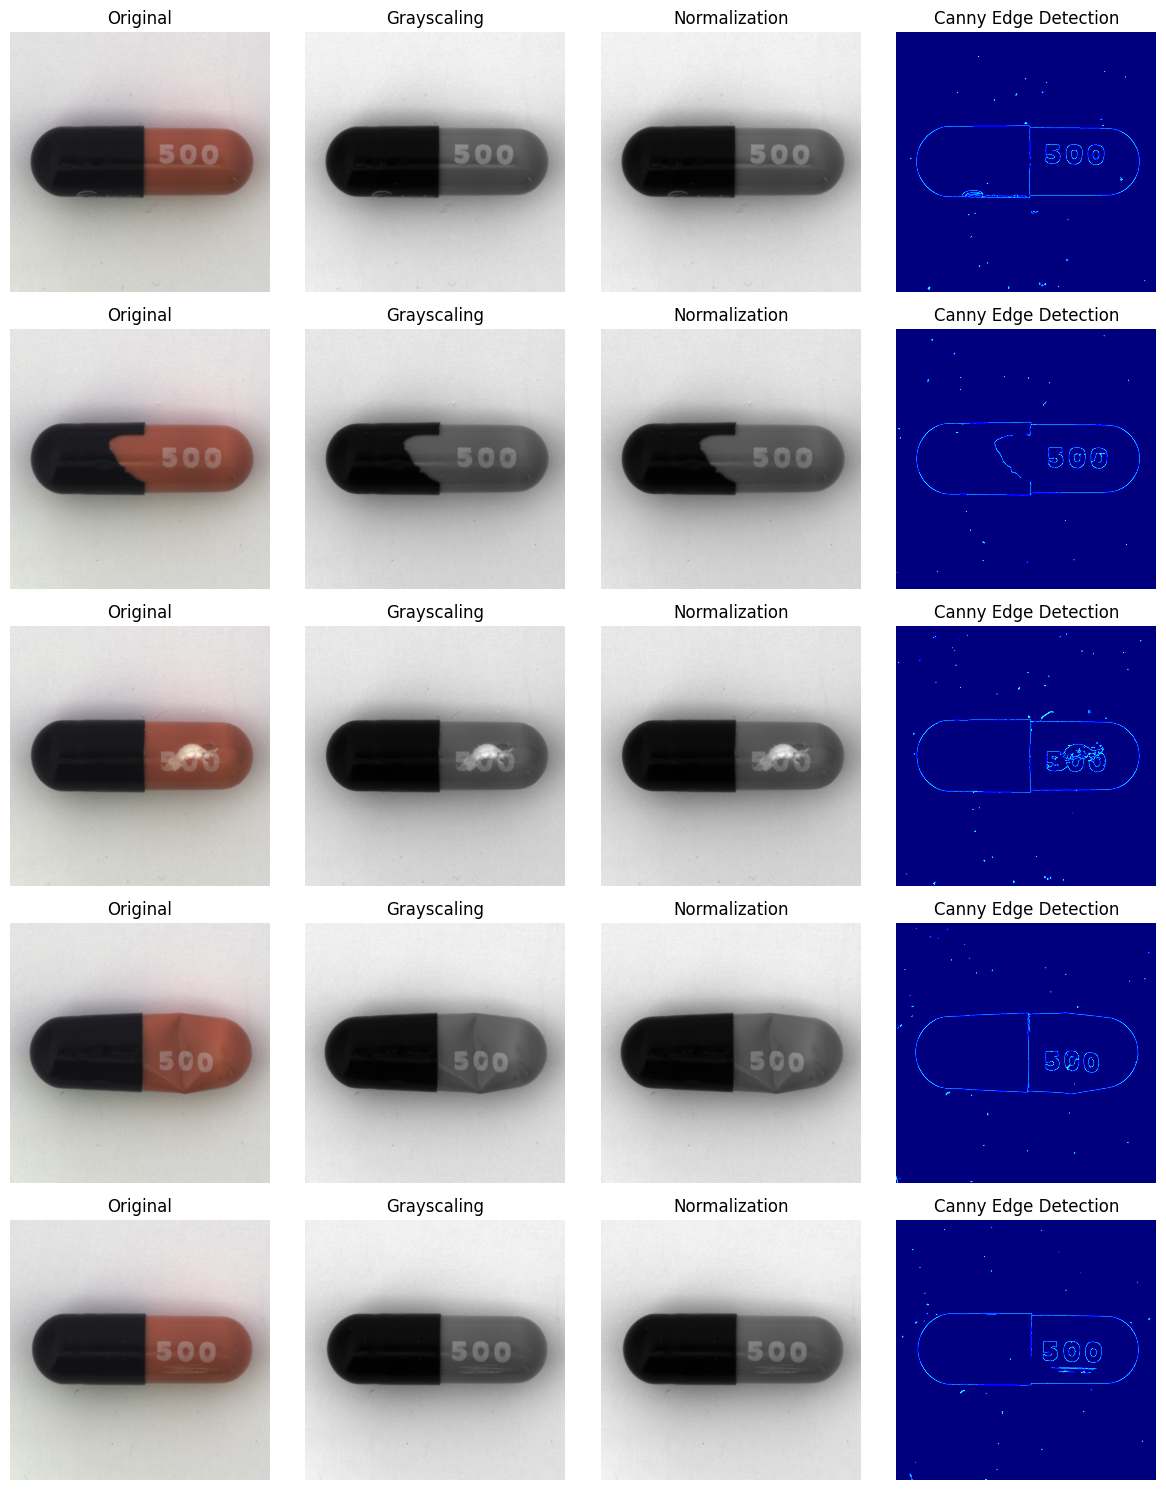

In [5]:
import os
import glob
from skimage import io, feature, exposure
from scipy.fft import fft2, fftshift
import numpy as np
import matplotlib.pyplot as plt
import cv2


image_paths = [
    "/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/good/000.png",
    "/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/crack/010.png",
    "/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/poke/000.png",
    "/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/squeeze/000.png",
    "/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/scratch/001.png"
]


# Preprocessing steps
preprocessing_steps = [
    "Original",
    "Grayscaling",
    "Normalization",
    "Canny Edge Detection"
]

fig, axes = plt.subplots(5, 4, figsize=(12, 15))

for i in range(len(image_paths)):
    original_image = cv2.imread(image_paths[i])
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title(preprocessing_steps[0])
    axes[i, 0].axis('off')

    # Apply grayscale conversion
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)

    # Display the grayscale image
    axes[i, 1].imshow(gray_image, cmap='gray')
    axes[i, 1].set_title(preprocessing_steps[1])
    axes[i, 1].axis('off')

    # Apply normalization
    normalized_image = gray_image / 255.0

    # Display the normalized image
    axes[i, 2].imshow(normalized_image, cmap='gray')
    axes[i, 2].set_title(preprocessing_steps[2])
    axes[i, 2].axis('off')

    # Apply Canny edge detection
    edges = cv2.Canny(np.uint8(normalized_image * 255.0), 30, 70)

    # Display the edges
    axes[i, 3].imshow(edges, cmap='jet')
    axes[i, 3].set_title(preprocessing_steps[3])
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

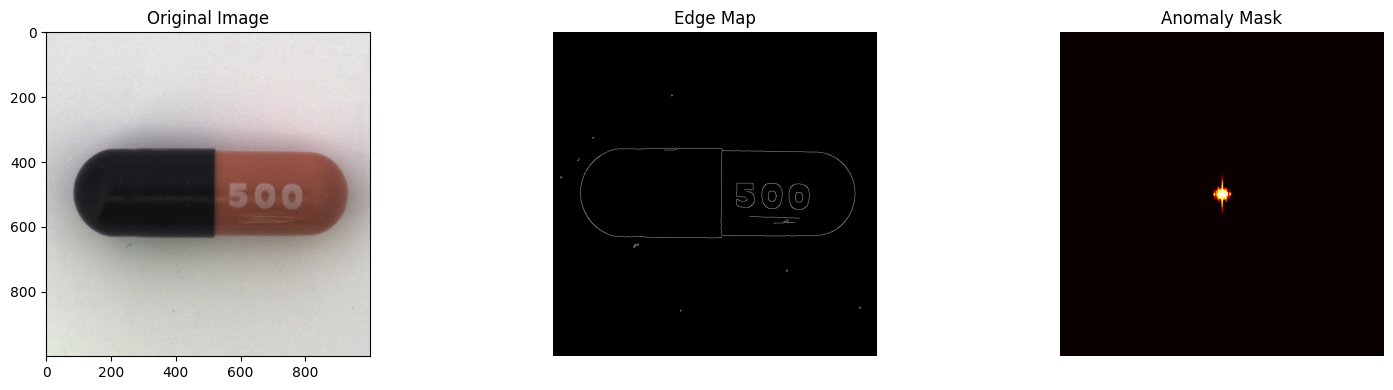

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, feature
from scipy.fft import fft2, fftshift


def detect_anomaly(image_path, threshold_factor=.5):
    image = io.imread(image_path)

    # Convert to grayscale if necessary
    if len(image.shape) > 2:
        image = np.mean(image, axis=2)

    # Normalization
    image = image / 255.0

    # Apply edge detection using the Canny algorithm
    edge_map = feature.canny(image)

    # Apply 2D FFT and shift the zero-frequency component to the center of the spectrum
    image_fft = fft2(image)
    image_fft_shifted = fftshift(image_fft)

    # Compute the magnitude spectrum
    magnitude_spectrum = np.abs(image_fft_shifted)

    # Calculate the threshold for anomaly detection
    threshold = np.mean(magnitude_spectrum) + threshold_factor * np.std(magnitude_spectrum)

    # Anomaly mask by combining magnitude spectrum thresholding and complement of the edge map
    anomaly_mask = np.logical_and(magnitude_spectrum > threshold, np.logical_not(edge_map))


    return edge_map, anomaly_mask


# Example usage
image_path = "/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/scratch/001.png"

edge_map, anomaly_mask = detect_anomaly(image_path)

# Combine the edge map and anomaly mask

# Plot the original image, edge map, anomaly mask, and combined image
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Plot the original image
axes[0].imshow(io.imread(image_path))
axes[0].set_title('Original Image')

# Plot the edge map in gray
axes[1].imshow(edge_map, cmap='gray')
axes[1].set_title('Edge Map')
axes[1].set_axis_off()

# Plot the anomaly mask in red
axes[2].imshow(anomaly_mask, cmap='hot')
axes[2].set_title('Anomaly Mask')
axes[2].set_axis_off()



plt.tight_layout()
plt.show()

In [7]:
import os
import glob
from skimage import io, feature, exposure
from scipy.fft import fft2, fftshift
import numpy as np
import matplotlib.pyplot as plt
import cv2


def binary_label_images(train_data, test_data):
    labels = {}

    # Assign label 0 for good images
    train_images = glob.glob(os.path.join(train_data, '*.png'))
    for img_path in train_images:
        labels[img_path] = 0

    # Assign label 1 for anomalous images
    for folder in test_data:
        test_images = glob.glob(os.path.join(folder, '*.png'))
        for img_path in test_images:
            labels[img_path] = 1

#     train_good_images = sum(label == 0 for label in labels.values())
#     print("No. Of Good Images", train_good_images)
#     test_images = sum(label == 1 for label in labels.values())
#     print("No. Of  Images" ,test_images)

    return labels


def detect_anomaly(image_path, threshold_factor=2.0, approach='default'):
    image = io.imread(image_path)

    # grayscale
    #if len(image.shape) > 2:
    #import pdb; pdb.set_trace() next line
    image = np.mean(image, axis=2)

    # Normalization
    image = image / 255.0

    # Canny edge detection
    edge_map = feature.canny(image)


    #  2D FFT and zero-frequency component to the center of the spectrum
    image_fft = fft2(image)
    image_fft_shifted = fftshift(image_fft)

    # magnitude spectrum
    magnitude_spectrum = np.abs(image_fft_shifted)


    # Threshold for anomaly detection
    threshold = np.mean(magnitude_spectrum) + threshold_factor * np.std(magnitude_spectrum)

    # Anomaly mask by combining magnitude spectrum thresholding and edge map
    anomaly_mask = np.logical_and(magnitude_spectrum > threshold, edge_map)

    # Binary classification based on the presence of anomalies
    if approach == 'default':
        if np.any(anomaly_mask):
            return 1  # Anomalies detected
        else:
            return 0  # No anomalies detected

#Function to evaluate accuracy,
def evaluate_accuracy(image_folders, truth_labels, approach='default', threshold_factor=0.5):
    predicted_labels = {}

    for folder in image_folders:
        image_paths = glob.glob(os.path.join(folder, '*.png'))
        for img_path in image_paths:
            predicted_label = detect_anomaly(img_path, threshold_factor, approach)
            predicted_labels[img_path] = predicted_label

    # Comparision of actual label vs predicted label
    num_correct = 0
    total_predictions = len(predicted_labels)
    wrongly_predicted_images = []

    for img_path, predicted_label in predicted_labels.items():
        truth_label = truth_labels[img_path]
        if predicted_label == truth_label:
            num_correct += 1
        else:
            wrongly_predicted_images.append(img_path)

    accuracy = num_correct / total_predictions
    print("Correctly Predicted Images:", num_correct )
    print("Total Images:", total_predictions)


    # Wrongly predicted ano_images as good
    for img_path in wrongly_predicted_images:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.rectangle(img, (0, 0), (img.shape[1], img.shape[0]), (0, 255, 0), 10)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    return accuracy


#Input images
train_folder = '/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/good'
test_folders = [
    '/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/crack',
    '/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/poke',
    '/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/squeeze',
    '/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/scratch',
    '/content/drive/MyDrive/Colab Notebooks/Anomaly Detection/capsule/test/faulty_imprint'

]



# call binary lalel fn.
truth_labels = binary_label_images(train_folder, test_folders)

# Call Evaluate accuracy fn.
approaches = ['default']
threshold_factors = [0.5, 0.75]

for a in approaches:
    for tf in threshold_factors:
        print(f"Approach: {a}, Threshold Factor: {tf}")
        test_accuracy = evaluate_accuracy(test_folders, truth_labels, a, tf)
        print("Testing Accuracy:", test_accuracy*100 , "%")

Output hidden; open in https://colab.research.google.com to view.